<a href="https://colab.research.google.com/github/dhruv2694/covid-detection-graduation/blob/main/Covid_Detection_(graduation)_(Imagenet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt

In [ ]:
%%time
dir = Path('/content/drive/MyDrive/Capstone_XRay_Data/COVID-19_Radiography_Dataset/New_More_Data')

filepaths = list(dir.glob(r'**/*.*'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

CPU times: user 55 ms, sys: 4.11 ms, total: 59.1 ms
Wall time: 3.47 s


,Filepath,Label
0,/content/drive/MyDrive/Capstone_XRay_Data/COVI...,pneumonia
1,/content/drive/MyDrive/Capstone_XRay_Data/COVI...,pneumonia
2,/content/drive/MyDrive/Capstone_XRay_Data/COVI...,pneumonia
3,/content/drive/MyDrive/Capstone_XRay_Data/COVI...,pneumonia
4,/content/drive/MyDrive/Capstone_XRay_Data/COVI...,pneumonia
...,...,...
1495,/content/drive/MyDrive/Capstone_XRay_Data/COVI...,normal
1496,/content/drive/MyDrive/Capstone_XRay_Data/COVI...,normal
1497,/content/drive/MyDrive/Capstone_XRay_Data/COVI...,normal
1498,/content/drive/MyDrive/Capstone_XRay_Data/COVI...,normal


In [ ]:
dataframe['Label'].value_counts()

pneumonia    500
covid        500
normal       500
Name: Label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
train , test = train_test_split(
 dataframe, test_size=0.10, random_state=0, stratify=dataframe['Label'])
train['Label'].value_counts()

pneumonia    450
normal       450
covid        450
Name: Label, dtype: int64

In [ ]:
test['Label'].value_counts()

normal       50
covid        50
pneumonia    50
Name: Label, dtype: int64

In [ ]:
from tensorflow.image import rgb_to_grayscale 

def pre_process(image):
    image = image = rgb_to_grayscale(image)
    return image

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
#     preprocessing_function=pre_process,
    rescale=1./255,
    
    validation_split=0.2
)

test_generator = ImageDataGenerator(
#     preprocessing_function=pre_process,
    rescale=1./255
)

In [ ]:
size=224
color_mode='rgb'
batch_size=32
train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)


val_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)


test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 1054 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 33 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


Found 263 validated image filenames belonging to 3 classes.
Found 146 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 33 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
test_images.class_indices

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [ ]:
from keras.layers import Layer, Conv2D, GlobalAveragePooling2D, Reshape, Multiply, Add, Activation
from keras import backend as K

def config_afr(input_shape, reduction_ratio=16):
    num_channels = input_shape[-1]
    num_reduced_filters = max(num_channels // reduction_ratio, 1)
    return num_channels, num_reduced_filters



class AFR(Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(AFR, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.num_channels, self.num_reduced_filters = config_afr(input_shape, self.reduction_ratio)
        self.fc1 = Conv2D(self.num_reduced_filters, kernel_size=(1, 1), strides=(1, 1), padding='same')
        self.relu1 = Activation('relu')
        self.fc2 = Conv2D(self.num_channels, kernel_size=(1, 1), strides=(1, 1), padding='same')
        self.sigmoid = Activation('sigmoid')
        super(AFR, self).build(input_shape)

    def call(self, inputs):
        x = GlobalAveragePooling2D()(inputs)
        x = Reshape((1, 1, self.num_channels))(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = Multiply()([inputs, x])
        x = Add()([inputs, x])
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(AFR, self).get_config()
        config['reduction_ratio'] = self.reduction_ratio
        return config

In [ ]:
from keras.layers import Input, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Model

pre_trained_model = VGG19(input_shape=(size,size,3), include_top=False, weights="imagenet")
for layer in pre_trained_model.layers:
    layer.trainable = False 
    
inputs = Input(shape=(size, size, 3))
x1 =pre_trained_model(inputs)

x4 = AFR(reduction_ratio=8)(x1)

x=Flatten()(x4)
x=Dense(512, activation='relu')(x)
x=Dense(128, activation='relu')(x)
x=Dense(3 , activation='softmax')(x)
model = Model(inputs=inputs, outputs=x)
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 afr (AFR)                   (None, 7, 7, 512)         66112     
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                              

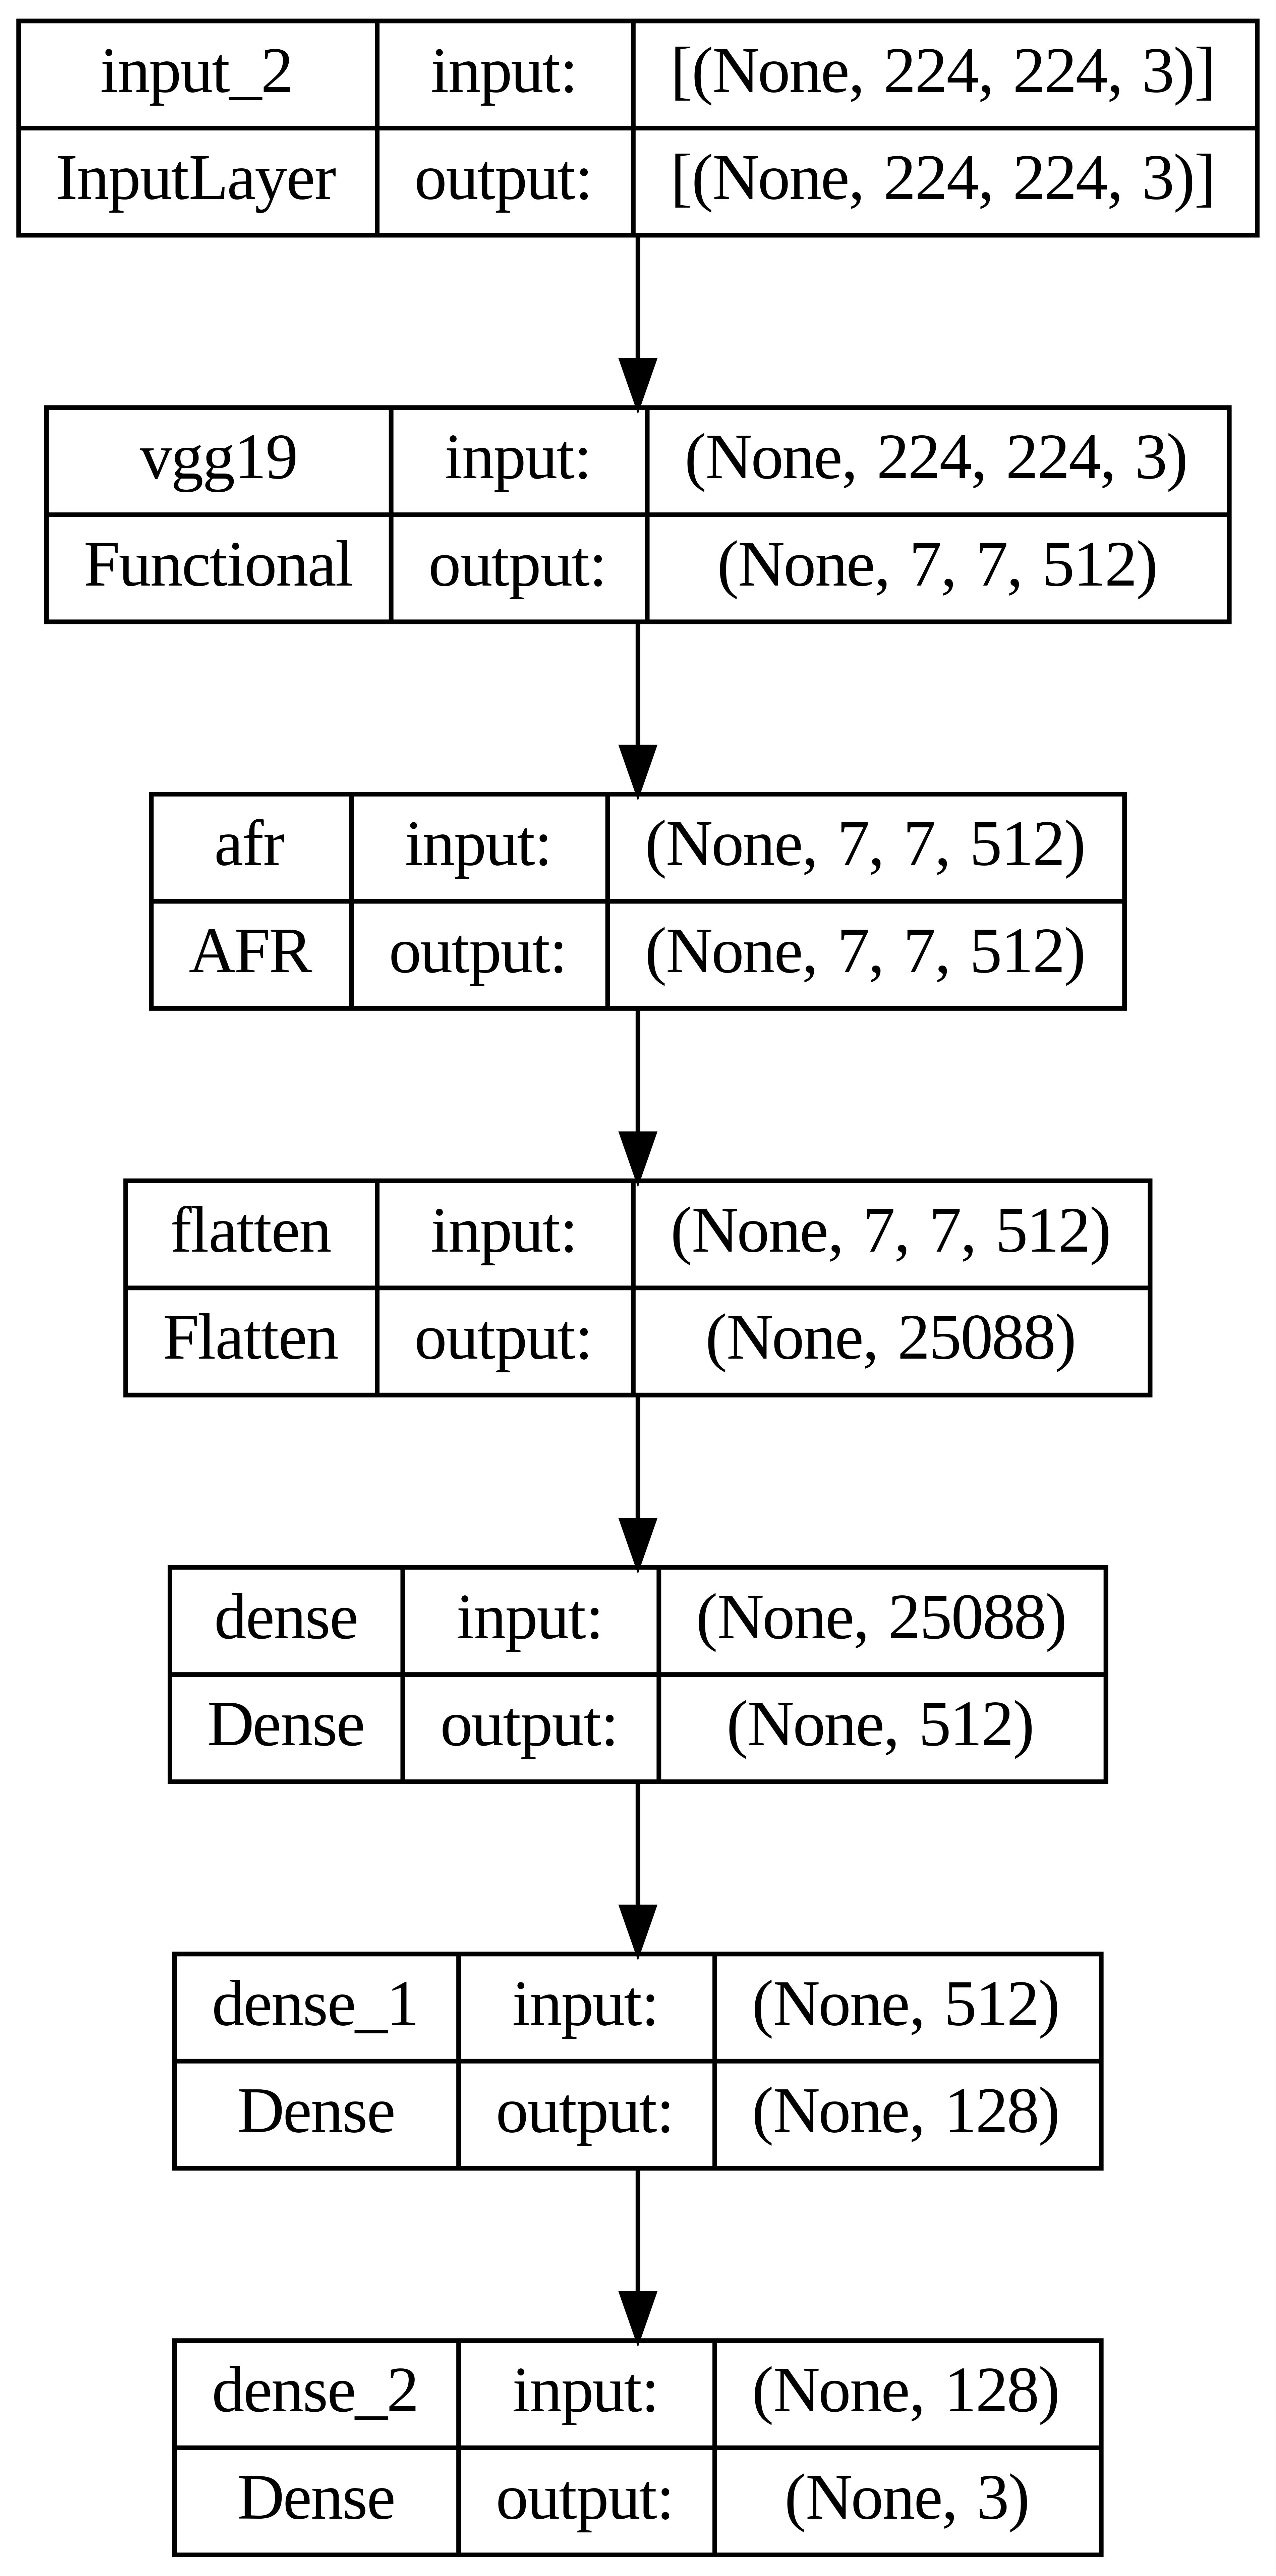

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file="model.jpg",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=1000
)

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
from tensorflow.keras.metrics import AUC 
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',
             'Precision',
             'Recall',
                    AUC(
                                    num_thresholds=200,
                                    curve="ROC",
                                    summation_method="interpolation",
                                    multi_label=False,
                                    from_logits=False)
        ]
)

In [ ]:
%%time
result=model.fit(
    train_images,
#     steps_per_epoch=4804//32,
    validation_data=val_images,
#     validation_steps=1201//32,
    epochs=10,
    callbacks=[checkpoint]
)

Epoch 1/10
33/33 [==============================] - ETA: 0s - loss: 2.2629 - accuracy: 0.6167 - precision: 0.6208 - recall: 0.6072 - auc: 0.7847 
Epoch 1: val_accuracy improved from -inf to 0.85171, saving model to best_model.h5
33/33 [==============================] - 959s 29s/step - loss: 2.2629 - accuracy: 0.6167 - precision: 0.6208 - recall: 0.6072 - auc: 0.7847 - val_loss: 0.3617 - val_accuracy: 0.8517 - val_precision: 0.8755 - val_recall: 0.8289 - val_auc: 0.9658
Epoch 2/10
33/33 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.8416 - precision: 0.8526 - recall: 0.8340 - auc: 0.9562 
Epoch 2: val_accuracy improved from 0.85171 to 0.86312, saving model to best_model.h5
33/33 [==============================] - 939s 29s/step - loss: 0.4119 - accuracy: 0.8416 - precision: 0.8526 - recall: 0.8340 - auc: 0.9562 - val_loss: 0.3383 - val_accuracy: 0.8631 - val_precision: 0.8716 - val_recall: 0.8517 - val_auc: 0.9699
Epoch 3/10
33/33 [==============================]

In [ ]:
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import cohen_kappa_score, f1_score
from keras.models import load_model

best_model=load_model('/content/best_model.h5', custom_objects={'AFR': AFR})
results = best_model.evaluate(test_images, verbose=0)
y_pred = best_model.predict(test_images)
y_pred=np.argmax(y_pred, axis=1)

print("     Test Loss: {:.4f}".format(results[0]))
print(" Test Accuracy: {:.2f}%".format(results[1] * 100))
print("Test Precision: {:.2f}%".format(results[2] * 100))
print("   Test Recall: {:.2f}%".format(results[3] * 100))
print(" Test f1-score: {:.2f}%".format(f1_score(test_images.labels, y_pred, average='micro') * 100))
print("      Test AUC: {:.4f}".format(results[4] ))
print("         Gmean: {:.2f}%".format(geometric_mean_score(test_images.labels, y_pred)*100) )
print("         kappa: {:.2f}%".format(cohen_kappa_score(test_images.labels, y_pred)*100) )

In [ ]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig( 'loss.jpg', dpi=500, bbox_inches = 'tight')

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig( 'accuracy.jpg', dpi=500, bbox_inches = 'tight')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_images.labels, y_pred)
print(cm)
print('classification report')

report = classification_report(test_images.labels, y_pred, target_names=['covid', 'normal', 'pneumonia'], digits=4)
print(report )

def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!='']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header)
    return df
report = report_to_df(report)

report.to_csv('classification report.csv', index=True)

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.rcParams['font.size'] = '12'
    
    
plot_confusion_matrix(cm, classes=['covid', 'normal', 'pneumonia'],normalize=False,title='Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion matrix' + '.jpg', dpi=500, bbox_inches = 'tight')

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.rcParams['font.size'] = '24'
    
    
plot_confusion_matrix(cm, classes=['covid', 'normal', 'pneumonia'],normalize=True,title='normalized Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('normalized confusion matrix' + '.jpg', dpi=500, bbox_inches = 'tight')